# Tuolumne River at 120 18-21 Vented Data Post Processing
Joe Ammatelli | May 2022

This notebook documents the steps taken to clean vented pressure transducer time series. In particular, this notebook faciliates the following postprocessing/quality control steps:
1. Inspection of the raw data
2. Conversion of the time series to the correct units
3. Resampling from 15 minutes to 30 minutes (to match the unvented levelogger time series)
4. Selection of a desired time span (from time series that often span many year)
6. Flagging of Ice Jams, sensor malfunctions, or sensor shifts
7. Identification and sensor shifts

Once all steps have been completed, a .csv file with the following quantities will be generated for each contiguous segment (period in the time series where there are no obvious sensor shifts):
* Date and time (UTC)
* vented pressure, cm
* water temperature, degrees C
* discharge flag

Author of Template and Underlying Code: Joe Ammatelli | (jamma@uw.edu) | May 2022

## Import Relevant Libraries and Set Plotting Theme
**Analyst TODO**: Run cells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join('..', '..', 'src')))

import config
import level_baro_utils

sys.path.remove(os.path.abspath(os.path.join('..', '..', 'src')))

In [2]:
sns.set_theme()

## Specify Site and Data Path
* assign an integer representing the site to the variable `sitecode`. Mappings are as follows (follows from upstream to downstream):
    * 0 : Lyell Below Maclure
    * 1 : Lyell Above Twin Bridges
    * 2 : Dana Fork at Bug Camp
    * 3 : Tuolumne River at Highway 120
    * 4 : Budd Creek
    * 5 : Delaney Above PCT
* assign a string representing the file name to the `vented_fn` variable (note only the file name is needed, not the path to the file)

These input parameters are used to automatically retrieve the correct raw data, populate the correct log file, label any plots with relevant site descriptors, and automatically write output with descriptive names.

In [3]:
sitecode = 3

vented_fn = 'Tuolumne120_324_T15min_20210812.dat'

## Load Data
**Analyst TODO**: 
* Modify the `pd.read_csv` function as appropriate for the given vented series (reading the data has not been abstracted away since the input vented pressure transducer time series often have different formatting). In particular, you may need to edit the `header`, `skiprows`, `index_col`, and `parse_dates` parameters. See the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) for more details.
* Inspect the column labels

In [4]:
vented_path = os.path.join('..', 'data', 'raw', vented_fn)

In [5]:
vented_df = pd.read_csv(vented_path, 
                        header=1, 
                        skiprows=[2,3], 
                        index_col=0, 
                        parse_dates=[0], 
                        infer_datetime_format=True)
vented_df.head()

,RECORD,BattV_Avg,Lvl_ft_1_Avg,Temp_C_1_Avg,Lvl_ft_2_Avg,Temp_C_2_Avg,MedianTurbidity_Avg,VarianceTurbidity_Avg,Temp_C_DTS12_Avg,AvgLvl_Avg,Observed_1,Lvl_ft_1_corr,Offset_1,Observed_2,Lvl_ft_2_corr,Offset_2
TIMESTAMP,,,,,,,,,,,,,,,,
2017-12-27 00:00:00,116838,12.96,3.444,3.872,3.456,3.967,0.15,0.000,0.1,3.450,2.96,2.574,-0.869,2.96,2.565,-0.891
2017-12-27 00:15:00,116839,12.95,3.444,3.874,3.456,3.959,0.14,0.001,0.1,3.450,2.96,2.575,-0.869,2.96,2.565,-0.891
2017-12-27 00:30:00,116840,12.94,3.443,3.875,3.455,3.953,0.18,0.001,0.1,3.449,2.96,2.573,-0.869,2.96,2.564,-0.891
2017-12-27 00:45:00,116841,12.93,3.443,3.880,3.455,3.951,0.20,0.001,0.1,3.449,2.96,2.574,-0.869,2.96,2.564,-0.891
2017-12-27 01:00:00,116842,12.90,3.443,3.846,3.455,3.935,0.17,0.001,0.1,3.449,2.96,2.574,-0.869,2.96,2.564,-0.891


In [6]:
vented_df.columns

Index(['RECORD', 'BattV_Avg', 'Lvl_ft_1_Avg', 'Temp_C_1_Avg', 'Lvl_ft_2_Avg',
       'Temp_C_2_Avg', 'MedianTurbidity_Avg', 'VarianceTurbidity_Avg',
       'Temp_C_DTS12_Avg', 'AvgLvl_Avg', 'Observed_1', 'Lvl_ft_1_corr',
       'Offset_1', 'Observed_2', 'Lvl_ft_2_corr', 'Offset_2'],
      dtype='object')

## Define Name of Level Field
**Analyst TODO**: Create a mapping between the level header in the original file and the naming convention used elsewhere in the processing.
* assign a string representing the name of the column storing level data to the variable `original_lvl_field_name`
* You should not need to modify the variable `new_lvl_field_name`
* NOTE: There is usually a column for raw level readings and corrected level measurements, which are tuned during each site visit by the Tuolumne staff. Discuss which column to use with Jessica.

In [7]:
original_lvl_field_name = 'AvgLvl_Avg'
new_lvl_field_name = 'lvl_cm'

## Convert to Correct Time Zone and Units
**Analyst TODO**: Verify correct conversions are being applied (default is to convert level from FT to CM and convert time from PDT to UTC)

In [8]:
# convert ft to cm and local time to UTC
vented_df[original_lvl_field_name] *= level_baro_utils.FT_TO_CM
vented_df.rename(columns={original_lvl_field_name:new_lvl_field_name}, inplace=True)
vented_df.index = vented_df.index + timedelta(hours=7)

## Resample (go from 15 minute data to 30 minute data)
**Analyst TODO**: Run cells

In [9]:
vented_df = level_baro_utils.resample_vented(vented_df)
vented_df.head()

,RECORD,BattV_Avg,Lvl_ft_1_Avg,Temp_C_1_Avg,Lvl_ft_2_Avg,Temp_C_2_Avg,MedianTurbidity_Avg,VarianceTurbidity_Avg,Temp_C_DTS12_Avg,lvl_cm,Observed_1,Lvl_ft_1_corr,Offset_1,Observed_2,Lvl_ft_2_corr,Offset_2
TIMESTAMP,,,,,,,,,,,,,,,,
2017-12-27 07:00:00,116838,12.96,3.444,3.872,3.456,3.967,0.15,0.000,0.1,105.15600,2.96,2.574,-0.869,2.96,2.565,-0.891
2017-12-27 07:30:00,116840,12.94,3.443,3.875,3.455,3.953,0.18,0.001,0.1,105.12552,2.96,2.573,-0.869,2.96,2.564,-0.891
2017-12-27 08:00:00,116842,12.90,3.443,3.846,3.455,3.935,0.17,0.001,0.1,105.12552,2.96,2.574,-0.869,2.96,2.564,-0.891
2017-12-27 08:30:00,116844,12.88,3.442,3.833,3.454,3.904,0.14,0.000,0.1,105.09504,2.96,2.573,-0.869,2.96,2.563,-0.891
2017-12-27 09:00:00,116846,12.85,3.441,3.828,3.454,3.909,0.14,0.001,0.1,105.06456,2.96,2.572,-0.869,2.96,2.563,-0.891


## Define the Time Range to Extract Data From and Post-Process
**Analyst TODO**: Choose the time range of interest (should cover the same years as the unprocessed Solinst levelogger datasets)
* assign a string representing the start date of trimmed time series to the variable `start` (format 'YYYY-MM-DD', e.g. 2018-06-01)
* assign a string representing the span of trimmed time series to the variable `span` (format 'YY-YY', e.g. 18-21)

In [10]:
start = '2018-06'
span = '18-21'

In [11]:
site_info = {'sitecode' : sitecode, 
             'site' : config.SITE_LONGNAME[sitecode], 
             'span' : span}

In [12]:
vented_range_df = vented_df[start:]
vented_range_ds = vented_range_df[new_lvl_field_name]

## Isolate Temperature Data
**Analyst TODO**:
* Assign a string representing the name of the column temperature data to the variable `temp_field_name`

**Note**: Here we had to change the work flow a bit since there were two temperature fields. In this case, we compare the two columns before taking the average of the two. 

In [13]:
temp1_field_name = 'Temp_C_1_Avg'
temp_C_1_ds = vented_range_df[temp1_field_name]

temp2_field_name = 'Temp_C_2_Avg'
temp_C_2_ds = vented_range_df[temp2_field_name]

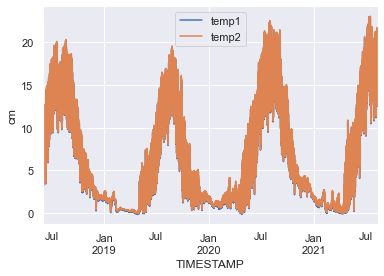

In [14]:
temp_C_1_ds.plot(ylabel='cm', label='temp1')
temp_C_2_ds.plot(ylabel='cm', label='temp2')
plt.legend()

In [15]:
average_difference = np.mean(np.absolute(temp_C_1_ds - temp_C_2_ds))
print(f'Average Difference: {average_difference} Degrees C')

Average Difference: 0.11939150195162915 Degrees C


This average difference corresponds to about 0.18F. Conclude data is similar enough and average for water temp time series. 

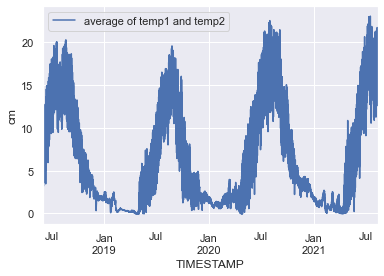

In [16]:
temp_C_ds = (temp_C_1_ds + temp_C_2_ds) / 2
temp_C_ds.plot(ylabel='cm', label='average of temp1 and temp2')
plt.legend()

## Inspect Time Range of Interest
**Analyst TODO**: Examine the time series a identify possible ice jams, sensor malfunctions, and sensor shifts

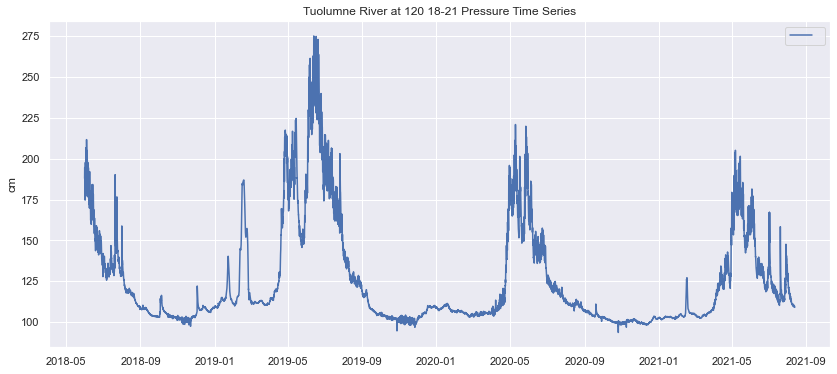

In [17]:
level_baro_utils.plot_multiple_pres_timeseries([vented_range_ds], [''], site_info)

## Inspect and Flag Ice Jams
**Analyst TODO**: Inspect all potential ice jams and sensor shifts. After all jams/shifts have been evaluated, add confirmed ice jams and sensor shifts to the appropriate list. 
1. For each ice jam/sensor shift candidate, create a new cell and encode the start and end date of the candidate. For example:
```
candidate_1 = {'start':'2018-12-1', 'end':'2018-12-6'}
level_baro_utils.plot_candidate(level_trimed_aligned_barocorrected_ds, candidate_1, site_info)
```
2. Ensure each candidate variable is numbered and that all numbers are unique (easiest to just have ascending numbers for each candidate)
3. Ensure the correct candidate is being passed to `level_baro_utils.plot_candidate` (i.e. after copying and pasting code into new cell, update the candidate number in both lines of code).
4. Run the cell and nspect the resultant plot.
5. If the candidate is determined to be an ice jam or sensor shift, add the candidate name to the approprioate list at the end of the section. If after evaluating all candidates there are no ice jams or sensor_shifts, assign a `None` to the appropriate variabel: e.g.:
```
ice_jams = [candidate_1]  # there is one ice jam
sensor_shifts = None      # there are no sensor shifts
```
6. **Important**: After deciding whether a segment is an ice jam or sensor shift, make a new Markdown cell below the cells and write record what the decision was and why (along with the date). Also note whether it was verified by Jessica or someone else with lots of domain knowledge/experience. 

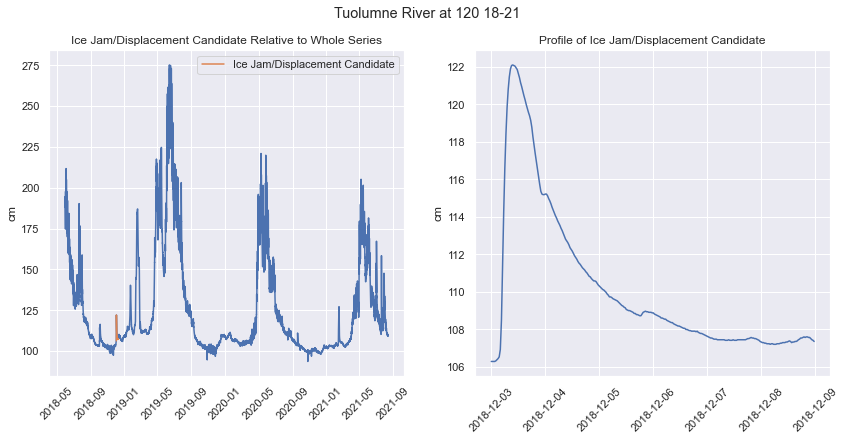

In [18]:
candidate_1 = {'start':'2018-12-3', 'end':'2018-12-08'}
level_baro_utils.plot_candidate(vented_range_ds, candidate_1, site_info)

**Verdict**: Textbook rain profile. No need to flag.

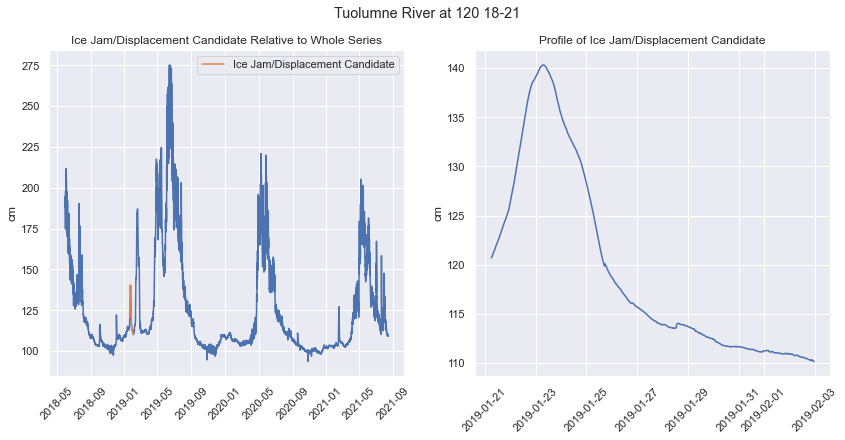

In [19]:
candidate_2 = {'start':'2019-1-21 6:00', 'end':'2019-2-2'}
level_baro_utils.plot_candidate(vented_range_ds, candidate_2, site_info)

**Verdict**: Smooth pofile and relatively small peak suggests rain. No need to flag. Confired by Jessica.

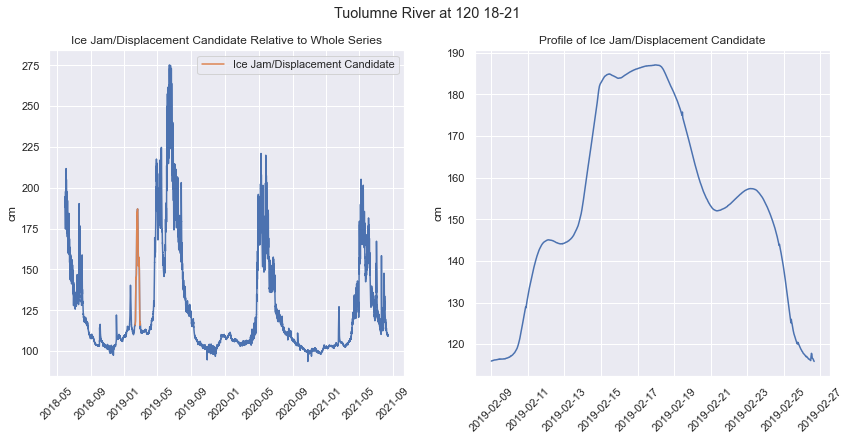

In [20]:
candidate_3 = {'start':'2019-2-9 0:00', 'end':'2019-2-26 16:00'}
level_baro_utils.plot_candidate(vented_range_ds, candidate_3, site_info)

**Verdict**: Same event observed for unvented. Likely melt + ice. Flag

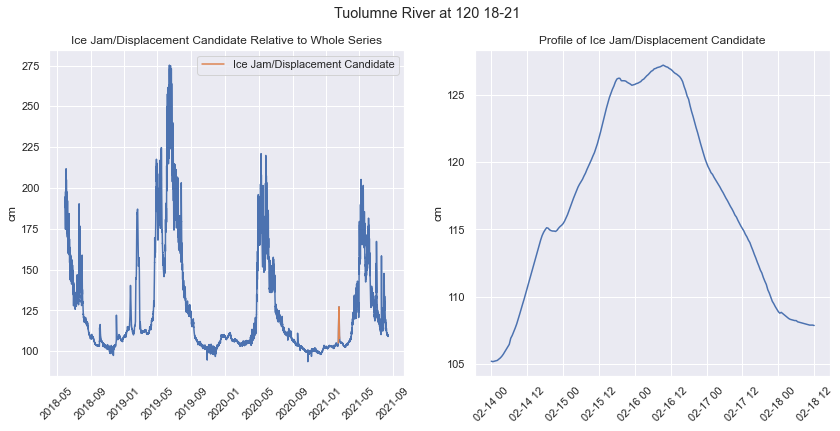

In [21]:
candidate_4 = {'start':'2021-02-14', 'end':'2021-02-18 12:00'}
level_baro_utils.plot_candidate(vented_range_ds, candidate_4, site_info)

**Verdict**: Nothing observed for same period in unvented data. Looks more like an ice jam than rain event. Flag. Jessica thinks size, agnitude, timing --> votes no flag.

In [22]:
ice_jams = [candidate_3, candidate_4]
sensor_shifts = None

## Create New Frame With All Desired Output Variables
**Analyst TODO**: Ensure tabular data has correct header fields. 

In [23]:
output_df = level_baro_utils.make_vented_output_df(vented_range_ds.index, vented_range_ds, temp_C_ds, ice_jams)

## Split Series at Sensor Shifts and Save Data
**Analyst TODO**: Make sure the number of segments is consistent with the number of sensor shifts defined above.

In [24]:
output_dfs = level_baro_utils.split_series_at_shifts(output_df, sensor_shifts)
print(f'Number of segments: {len(output_dfs)}')

Number of segments: 1


## Save Output Data
**Analyst TODO**: Verify correct number of output files and verify file names and paths

In [25]:
level_baro_utils.save_vented_timeseries(output_dfs, site_info)

Wrote segment 0 to ../data/processed/Tuolumne@120_18-21_vented_0.csv
